In [1]:
%matplotlib inline

import pandas as pd
import scanpy as sc
import numpy as np
import matplotlib.pyplot as plt
import scipy.sparse as sp
from scipy.stats import pearsonr

from scipy.cluster.hierarchy import linkage
import scipy.spatial.distance as ssd
from matplotlib.pyplot import rc_context

import seaborn as sns
import sys
from scipy.sparse import hstack, csr_matrix
from sklearn.feature_selection import mutual_info_classif
import os
from cnmf import cNMF, load_df_from_npz
import harmonypy
sys.path.append('../../../Code/')
# from utils import TCAT

from sklearn import metrics
from utils import read_dataset_log
import harmonypy as hm
from sklearn.preprocessing import MinMaxScaler
from adjustText import adjust_text

from datashader.mpl_ext import dsshow
import datashader as ds



In [32]:
from matplotlib import rcParams, font_manager
import matplotlib


rcParams['pdf.fonttype'] = 42
rcParams['ps.fonttype'] = 42
rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['Arial']
label_fontsize = 10
tick_fontsize = 8

In [2]:
import matplotlib.colors
cmap = plt.cm.hsv
cmaplist = [cmap(i) for i in range(cmap.N)]
cmaplist = cmaplist[0:round(len(cmaplist)*0.7)]
cmaplist.reverse()
cmap = matplotlib.colors.LinearSegmentedColormap.from_list('', cmaplist, cmap.N)


In [3]:
figdir = '../../../Figures/Components'

In [3]:
! pwd

/data/srlab1/TCAT/Analysis/PerDataset/Sparks


In [4]:
params = read_dataset_log('Dataset Paths')
params.index = params['dataset']
params

,dataset,usage_fn,gene_scores_fn,gene_tpm_fn,tcat_fn,tcat_fn_withsingletons,manual_gating_fn,manual_activation_gating_fn,activation_score_fn,metadata_fn,...,k,dt,processed_forcnmf_fn,tpm_counts_for_cnmf_fn,raw_counts_filt_fn,raw_counts_fn,dataset_type,tissue_type,context_label,tcat_fn_old
dataset,,,,,,,,,,,,,,,,,,,,,
AMP-RA,AMP-RA,/data/srlab1/TCAT/Data/PerDataset/AMPRA/AMPRA....,/data/srlab1/TCAT/Data/PerDataset/AMPRA/AMPRA....,/data/srlab1/TCAT/Data/PerDataset/AMPRA/AMPRA....,/data/srlab1/TCAT/Data/TCAT/TCAT_Usage.2023101...,/data/srlab1/TCAT/Data/TCAT/TCAT_Usage.2023101...,NaN,/data/srlab1/TCAT/Data/PerDataset/AMPRA/Manual...,/data/srlab1/TCAT/Data/PerDataset/AMPRA/Activa...,/data/srlab1/TCAT/Data/PerDataset/AMPRA/AMP_AD...,...,34.0,0_15,/data/srlab1/TCAT/Data/PerDataset/AMPRA/AMP_AD...,/data/srlab1/TCAT/Data/PerDataset/AMPRA/AMP_AD...,/data/srlab1/TCAT/Data/PerDataset/AMPRA/AMP_AD...,/data/srlab1/TCAT/Data/PerDataset/AMPRA/AMP_AD...,discovery,Synovium,RA+OA,/data/srlab1/TCAT/Data/TCAT/TCAT_Usage.2023101...
Pan-Cancer,Pan-Cancer,/data/srlab1/TCAT/Data/PerDataset/Pancancer/Pa...,/data/srlab1/TCAT/Data/PerDataset/Pancancer/Pa...,/data/srlab1/TCAT/Data/PerDataset/Pancancer/Pa...,/data/srlab1/TCAT/Data/TCAT/TCAT_Usage.2023101...,/data/srlab1/TCAT/Data/TCAT/TCAT_Usage.2023101...,NaN,NaN,/data/srlab1/TCAT/Data/PerDataset/Pancancer/Ac...,/data/srlab1/TCAT/Data/PerDataset/Pancancer/pa...,...,38.0,0.15,/data/srlab1/TCAT/Data/PerDataset/Pancancer/pa...,NaN,/data/srlab1/TCAT/Data/PerDataset/Pancancer/pa...,/data/srlab1/TCAT/Data/PerDataset/Pancancer/pa...,discovery,Pan-Tissue,Cancer+Healthy,/data/srlab1/TCAT/Data/TCAT/TCAT_Usage.2023101...
TBRU,TBRU,/data/srlab1/TCAT/Data/PerDataset/TBRU/TBRU.20...,/data/srlab1/TCAT/Data/PerDataset/TBRU/TBRU.20...,/data/srlab1/TCAT/Data/PerDataset/TBRU/TBRU.20...,/data/srlab1/TCAT/Data/TCAT/TCAT_Usage.2023101...,/data/srlab1/TCAT/Data/TCAT/TCAT_Usage.2023101...,NaN,/data/srlab1/TCAT/Data/PerDataset/TBRU/ManualG...,/data/srlab1/TCAT/Data/PerDataset/TBRU/Activat...,/data/srlab1/TCAT/Data/PerDataset/TBRU/tbru_ex...,...,36.0,0_20,/data/srlab1/TCAT/Data/PerDataset/TBRU/tbru_ex...,/data/srlab1/TCAT/Data/PerDataset/TBRU/tbru_ex...,/data/srlab1/TCAT/Data/PerDataset/TBRU/tbru_ex...,/data/srlab1/TCAT/Data/PerDataset/TBRU/tbru_ex...,discovery,Blood,Healthy,/data/srlab1/TCAT/Data/TCAT/TCAT_Usage.2023101...
HIV-Vaccine,HIV-Vaccine,/data/srlab1/TCAT/Data/PerDataset/HaoEtAl/HIVV...,/data/srlab1/TCAT/Data/PerDataset/HaoEtAl/HIVV...,/data/srlab1/TCAT/Data/PerDataset/HaoEtAl/HIVV...,/data/srlab1/TCAT/Data/TCAT/TCAT_Usage.2023101...,/data/srlab1/TCAT/Data/TCAT/TCAT_Usage.2023101...,/data/srlab1/TCAT/Data/PerDataset/HaoEtAl/Manu...,NaN,/data/srlab1/TCAT/Data/PerDataset/HaoEtAl/Acti...,/data/srlab1/TCAT/Data/PerDataset/HaoEtAl/haoe...,...,31.0,0_15,/data/srlab1/TCAT/Data/PerDataset/HaoEtAl/haoe...,/data/srlab1/TCAT/Data/PerDataset/HaoEtAl/haoe...,/data/srlab1/TCAT/Data/PerDataset/HaoEtAl/haoe...,/data/srlab1/TCAT/Data/PerDataset/HaoEtAl/haoe...,discovery,Blood,Post-Vaccine+Healthy,/data/srlab1/TCAT/Data/TCAT/TCAT_Usage.2023101...
UK-Covid,UK-Covid,/data/srlab1/TCAT/Data/PerDataset/UKCOVID/UKCO...,/data/srlab1/TCAT/Data/PerDataset/UKCOVID/UKCO...,/data/srlab1/TCAT/Data/PerDataset/UKCOVID/UKCO...,/data/srlab1/TCAT/Data/TCAT/TCAT_Usage.2023101...,/data/srlab1/TCAT/Data/TCAT/TCAT_Usage.2023101...,/data/srlab1/TCAT/Data/PerDataset/UKCOVID/Manu...,/data/srlab1/TCAT/Data/PerDataset/UKCOVID/Manu...,/data/srlab1/TCAT/Data/PerDataset/UKCOVID/Acti...,/data/srlab1/TCAT/Data/PerDataset/UKCOVID/hani...,...,44.0,0_20,/data/srlab1/TCAT/Data/PerDataset/UKCOVID/hani...,NaN,/data/srlab1/TCAT/Data/PerDataset/UKCOVID/hani...,/data/srlab1/TCAT/Data/PerDataset/UKCOVID/hani...,discovery,Blood,Covid-19+Healthy,/data/srlab1/TCAT/Data/TCAT/TCAT_Usage.2023101...
COMBAT,COMBAT,/data/srlab1/TCAT/Data/PerDataset/COMBAT/COMBA...,/data/srlab1/TCAT/Data/PerDataset/COMBAT/COMBA...,/data/srlab1/TCAT/Data/PerDataset/COMBAT/COMBA...,/data/srlab1/TCAT/Data/TCA

In [5]:
dataset = 'Sparks'

usage = pd.read_csv(params.loc[dataset, 'tcat_fn'], index_col = 0, sep = '\t')

rename = read_dataset_log('cGEP_Name')
rename_map = dict(zip(rename['cGep_Name'], rename['Short_Name']))
usage.columns = usage.columns.map(rename_map)
usage_norm = usage.div(usage.sum(axis=1), axis=0)

In [6]:
len(list(usage.columns)), len(list(usage.columns.unique()))

(52, 52)

In [7]:
gating = pd.read_csv(params.loc[dataset, 'manual_gating_fn'], index_col = 0, sep = '\t',
                     header=0, names = ['cell_gating'])

meta = pd.read_csv(params.loc[dataset, 'metadata_fn'], index_col = 0, sep = '\t')
meta['cell_gating'] = gating.loc[meta.index, 'cell_gating']
meta = meta.loc[usage_norm.index, ]

cluster_col = params.loc[dataset, 'cluster_col']

/PHShome/mc1070/anaconda3/envs/cnmf_env2v2/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3524: DtypeWarning: Columns (12) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [8]:
individual_col = params.loc[dataset, 'individual_col']
sample_col = params.loc[dataset, 'sample_col']

In [9]:
params.loc[dataset, 'metadata_fn']

'/data/srlab1/TCAT/Data/PerDataset/Sparks2023/T_fromSeuratmetadata_RNAClustering_withSampID.tsv'

In [10]:
meta.head(3)

,alt.subject.id,visit,covid.diagnosis.start.date.to.sample.drawn,group,sex,age,race,ethnicity,flu.vax.count.10yr,vaccine,...,leiden_res2_25,leiden_res2,leiden_res1_75,leiden_res1_5,leiden_res1_25,leiden_res0_75,leiden_res0_5,leiden_res0_25,alt.sample.id,cell_gating
Batch1_COVFLU_CITE_multi5P09_GCATGCGCAGCCTATA-1,Control,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,5,5,5,4,0,0,0,0,Control,CD4_Naive
Batch1_COVFLU_CITE_multi5P02_TTGTAGGCAGTATCTG-1,Control,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1,1,1,1,2,4,1,1,Control,CD4_CM
Batch1_COVFLU_CITE_multi5P02_GATGCTACAGCTTAAC-1,Control,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,2,2,2,0,1,2,0,0,Control,CD4_Naive


In [22]:
original =  '../../../Data/PerDataset/Sparks2023/T_fromSeurat.h5ad'
toadd = ''
paths = {
        'Original' : original, # AnnData containing RNA +/- ADT,
        'RNA_LogTP10K_Varnorm_Harmony':original.replace('.h5ad', toadd + 'RNA.LogTP10K.Varnorm.Harmony.h5ad'),
        'Metadata_RNAClustering' : original.replace('.h5ad', toadd + 'metadata_RNAClustering.tsv')
        }
paths

{'Original': '../../../Data/PerDataset/Sparks2023/T_fromSeurat.h5ad',
 'RNA_LogTP10K_Varnorm_Harmony': '../../../Data/PerDataset/Sparks2023/T_fromSeuratRNA.LogTP10K.Varnorm.Harmony.h5ad',
 'Metadata_RNAClustering': '../../../Data/PerDataset/Sparks2023/T_fromSeuratmetadata_RNAClustering.tsv'}

In [25]:
paths

{'Original': '../../../Data/PerDataset/Sparks2023/T_fromSeurat.h5ad',
 'RNA_LogTP10K_Varnorm_Harmony': '../../../Data/PerDataset/Sparks2023/T_fromSeuratRNA.LogTP10K.Varnorm.Harmony.h5ad',
 'Metadata_RNAClustering': '../../../Data/PerDataset/Sparks2023/T_fromSeuratmetadata_RNAClustering.tsv',
 'CC_Score_Scanpy': '../../../Data/PerDataset/Sparks2023/T_fromSeuratRNA.LogTP10K.Varnorm.CellCycleScore_Scanpy.tsv'}

In [24]:
paths.update({
        'CC_Score_Scanpy':paths['RNA_LogTP10K_Varnorm_Harmony'].replace('Harmony.h5ad', 'CellCycleScore_Scanpy.tsv')

})
paths

{'Original': '../../../Data/PerDataset/Sparks2023/T_fromSeurat.h5ad',
 'RNA_LogTP10K_Varnorm_Harmony': '../../../Data/PerDataset/Sparks2023/T_fromSeuratRNA.LogTP10K.Varnorm.Harmony.h5ad',
 'Metadata_RNAClustering': '../../../Data/PerDataset/Sparks2023/T_fromSeuratmetadata_RNAClustering.tsv',
 'CC_Score_Scanpy': '../../../Data/PerDataset/Sparks2023/T_fromSeuratRNA.LogTP10K.Varnorm.CellCycleScore_Scanpy.tsv'}

In [11]:
dataset = 'Sparks'
adata = sc.read(params.loc[dataset, 'raw_counts_filt_fn'])
adata_RNA = adata[:, adata.var['feature_types'] == 'Gene Expression']

In [12]:
sc.pp.normalize_per_cell(adata_RNA, counts_per_cell_after=1e4)

sc.pp.log1p(adata_RNA)
sc.pp.scale(adata_RNA)

/PHShome/mc1070/anaconda3/envs/cnmf_env2v2/lib/python3.7/site-packages/scanpy/preprocessing/_simple.py:524: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs[key_n_counts] = counts_per_cell


In [13]:
adata_RNA

AnnData object with n_obs × n_vars = 336739 × 28402
    obs: 'alt.subject.id', 'visit', 'covid.diagnosis.start.date.to.sample.drawn', 'group', 'sex', 'age', 'race', 'ethnicity', 'flu.vax.count.10yr', 'vaccine', 'vaccine.side.effects', 'long.covid.symptoms', 'Batch', 'nCount_RNA', 'nCount_HTO', 'nCount_CITE', 'nCount_RNA_largest.gene', 'nCount_SCT', 'nFeature_RNA', 'nFeature_HTO', 'nFeature_CITE', 'nFeature_SCT', 'percent.mt', 'percent.largest.gene', 'coarse.cell.type', 'cell.type', 'HTO1', 'HTO2', 'HTO3', 'n_counts', 'leiden_res1', 'leiden_res0_8', 'leiden_res0_6', 'leiden_res2_25', 'leiden_res2', 'leiden_res1_75', 'leiden_res1_5', 'leiden_res1_25', 'leiden_res0_75', 'leiden_res0_5', 'leiden_res0_25'
    var: 'gene_ids', 'feature_types', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'hvg', 'leiden', 'log1p', 'neighbors', 'pca', 'umap'
    obsm: 'X_harmony_RNA_UMAP', 'X_pca', 'X_pca_harmony', 'X_umap'
    varm: 'PCs'
    obsp: 'connectivities', 'd

## Score cell-cycle

In [13]:
!pwd

/data/srlab1/TCAT/Analysis/PerDataset/Sparks


In [14]:
cell_cycle_genes = [x.strip() for x in open('../../../Data/Misc/regev_lab_cell_cycle_genes.txt')]


In [15]:
s_genes = cell_cycle_genes[:43]
g2m_genes = cell_cycle_genes[43:]
cell_cycle_genes = [x for x in cell_cycle_genes if x in adata_RNA.var_names]

In [16]:
sc.tl.score_genes_cell_cycle(adata_RNA, s_genes=s_genes, g2m_genes=g2m_genes)


In [19]:
adata_RNA

AnnData object with n_obs × n_vars = 336739 × 28402
    obs: 'alt.subject.id', 'visit', 'covid.diagnosis.start.date.to.sample.drawn', 'group', 'sex', 'age', 'race', 'ethnicity', 'flu.vax.count.10yr', 'vaccine', 'vaccine.side.effects', 'long.covid.symptoms', 'Batch', 'nCount_RNA', 'nCount_HTO', 'nCount_CITE', 'nCount_RNA_largest.gene', 'nCount_SCT', 'nFeature_RNA', 'nFeature_HTO', 'nFeature_CITE', 'nFeature_SCT', 'percent.mt', 'percent.largest.gene', 'coarse.cell.type', 'cell.type', 'HTO1', 'HTO2', 'HTO3', 'n_counts', 'leiden_res1', 'leiden_res0_8', 'leiden_res0_6', 'leiden_res2_25', 'leiden_res2', 'leiden_res1_75', 'leiden_res1_5', 'leiden_res1_25', 'leiden_res0_75', 'leiden_res0_5', 'leiden_res0_25', 'S_score', 'G2M_score', 'phase'
    var: 'gene_ids', 'feature_types', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'hvg', 'leiden', 'log1p', 'neighbors', 'pca', 'umap'
    obsm: 'X_harmony_RNA_UMAP', 'X_pca', 'X_pca_harmony', 'X_umap'
    varm: 'PC

In [18]:
cc_scores = adata_RNA.obs[['S_score', 'G2M_score', 'phase']]

In [19]:
cc_scores

,S_score,G2M_score,phase
Batch1_COVFLU_CITE_multi5P09_GCATGCGCAGCCTATA-1,0.041558,-0.101888,S
Batch1_COVFLU_CITE_multi5P02_TTGTAGGCAGTATCTG-1,0.121614,0.135110,G2M
Batch1_COVFLU_CITE_multi5P02_GATGCTACAGCTTAAC-1,-0.044462,0.028720,G2M
Batch1_COVFLU_CITE_multi5P03_AGGGTGACATTAGGCT-1,-0.073695,-0.001312,G1
Batch1_COVFLU_CITE_multi5P10_GAACCTACAACGCACC-1,-0.091075,0.222605,G2M
...,...,...,...
Batch3_COVFLU_CITE_multi5P16_TTCGAAGGTCTCTTTA-1,0.117116,-0.039742,S
Batch3_COVFLU_CITE_multi5P09_CTCGTACGTAGGACAC-1,-0.198666,-0.093061,G1
Batch3_COVFLU_CITE_multi5P09_ACGGCCACAAGAAGAG-1,0.115477,-0.100814,S
Batch3_COVFLU_CITE_multi5P07_GAGTCCGCACACAGAG-1,-0.053386,-0.042489,G1


In [26]:
cc_scores.to_csv( '../../../Data/PerDataset/Sparks2023/CellCycleScore_Scanpy.tsv', sep = '\t')

## Plot cell-cycle and mitochondrial reads

In [48]:
cc_scores = pd.read_csv(paths['CC_Score_Scanpy'], index_col = 0, sep = '\t')

In [51]:
X = meta.copy()
X[usage_norm.columns] = usage_norm.loc[meta.index, :].copy()

In [54]:
X[cc_scores.columns] = cc_scores.loc[meta.index, :].copy()

In [50]:
meta.columns

Index(['alt.subject.id', 'visit', 'covid.diagnosis.start.date.to.sample.drawn',
       'group', 'sex', 'age', 'race', 'ethnicity', 'flu.vax.count.10yr',
       'vaccine', 'vaccine.side.effects', 'long.covid.symptoms', 'Batch',
       'nCount_RNA', 'nCount_HTO', 'nCount_CITE', 'nCount_RNA_largest.gene',
       'nCount_SCT', 'nFeature_RNA', 'nFeature_HTO', 'nFeature_CITE',
       'nFeature_SCT', 'percent.mt', 'percent.largest.gene',
       'coarse.cell.type', 'cell.type', 'HTO1', 'HTO2', 'HTO3', 'n_counts',
       'leiden_res1', 'leiden_res0_8', 'leiden_res0_6', 'leiden_res2_25',
       'leiden_res2', 'leiden_res1_75', 'leiden_res1_5', 'leiden_res1_25',
       'leiden_res0_75', 'leiden_res0_5', 'leiden_res0_25', 'alt.sample.id',
       'cell_gating'],
      dtype='object')

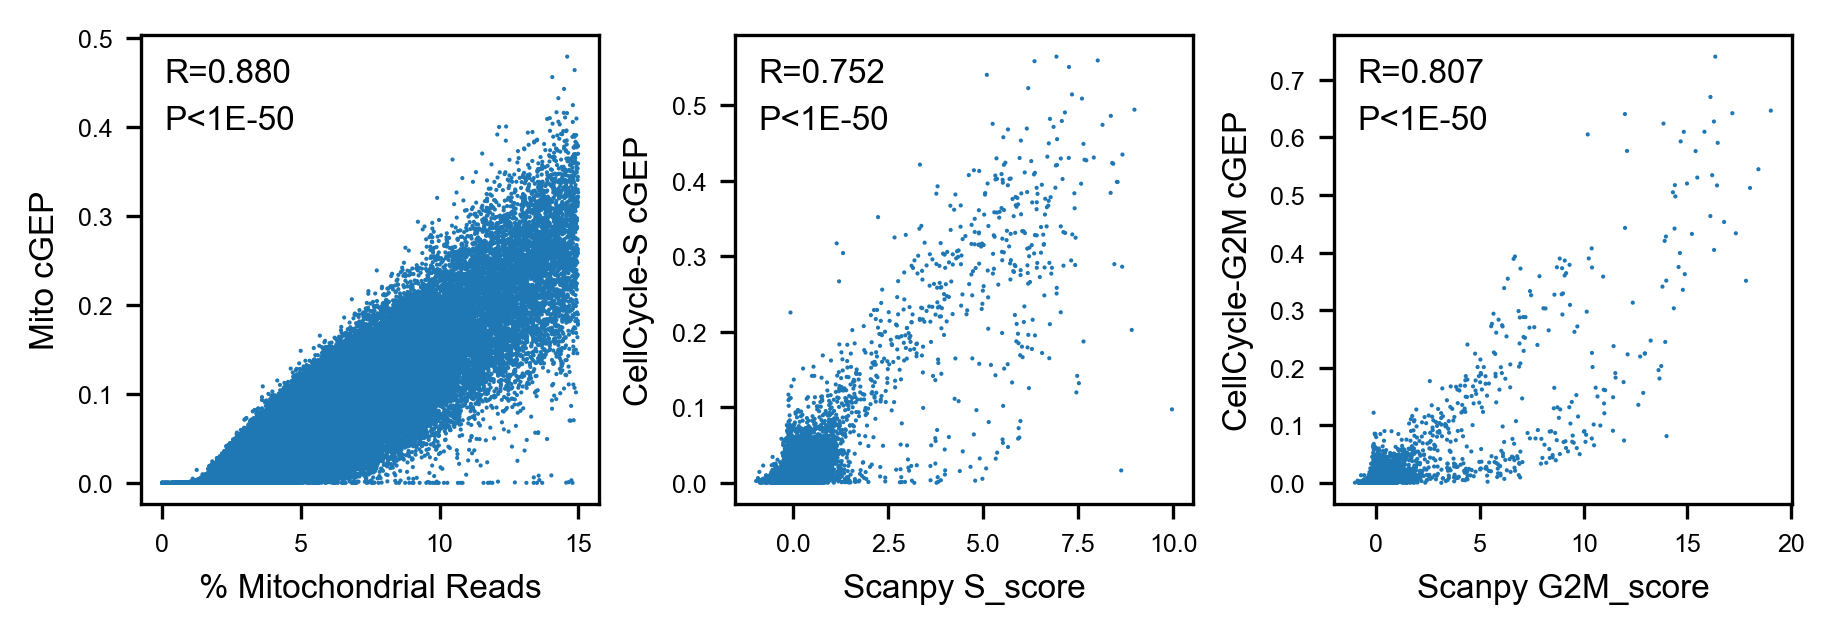

In [70]:
ncol = 3
fig, axes = plt.subplots(nrows = 1, ncols = ncol, dpi = 300, 
                         figsize = (6, 2), constrained_layout = True)

score = 'percent.mt'
gep = 'Mito'
x = X.loc[:, score] ## G2M score, S score
y = X.loc[:, gep]
r, p = pearsonr(x, y)

if p==0.0:
    plab = 'P<1E-50'
else:
    plab = 'P=%.3E' % p

ax = axes[0]
ax.scatter(x = x, y = y, edgecolors='none', s = 1)
ax.text(x = .05, y = .9, s = 'R=%.3f' % r, transform=ax.transAxes, size = 8)
ax.text(x = .05, y = .8, s = plab, transform=ax.transAxes, size = 8)
ax.set_xlabel('% Mitochondrial Reads', fontsize = 8)
ax.set_ylabel('%s cGEP' % gep, fontsize = 8)
ax.tick_params('both', labelsize = 6)


score = 'S_score'
gep = 'CellCycle-S'
x = X.loc[:, score] ## G2M score, S score
y = X.loc[:, gep]
r, p = pearsonr(x, y)

if p==0.0:
    plab = 'P<1E-50'
else:
    plab = 'P=%.3E' % p

ax = axes[1]
ax.scatter(x = x, y = y, edgecolors='none', s = 1)
ax.text(x = .05, y = .9, s = 'R=%.3f' % r, transform=ax.transAxes, size = 8)
ax.text(x = .05, y = .8, s = plab, transform=ax.transAxes, size = 8)
ax.set_xlabel('Scanpy %s' % score, fontsize = 8)
ax.set_ylabel('%s cGEP' % gep, fontsize = 8)
ax.tick_params('both', labelsize = 6)


score = 'G2M_score'
gep = 'CellCycle-G2M'
x = X.loc[:, score] ## G2M score, S score
y = X.loc[:, gep]
r, p = pearsonr(x, y)

if p==0.0:
    plab = 'P<1E-50'
else:
    plab = 'P:%.3E' % p

ax = axes[2]
ax.scatter(x = x, y = y, edgecolors='none', s = 1)
ax.text(x = .05, y = .9, s = 'R=%.3f' % r, transform=ax.transAxes, size = 8)
ax.text(x = .05, y = .8, s = plab, transform=ax.transAxes, size = 8)
ax.set_xlabel('Scanpy %s' % score, fontsize = 8)
ax.set_ylabel('%s cGEP' % gep, fontsize = 8)
ax.tick_params('both', labelsize = 6)


plt.savefig(os.path.join(figdir, 'FunctionalCorrelations_Sparks.png'), bbox_inches="tight")
plt.savefig(os.path.join(figdir, 'FunctionalCorrelations_Sparks.pdf'), bbox_inches="tight")
